In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy import symbols
from itertools import pairwise
import math
from queue import PriorityQueue
from moviepy.editor import ImageSequenceClip
import time
import cv2

In [ ]:
# Defining constant values and colors
height = 50
width = 180
linear_threshold = 0.5
angular_threshold = 30
clearance = 2
BACKGROUND_COLOR = (232,215,241)
OBSTACLE_COLOR = (74,48,109)
PATH_COLOR =  (255, 192, 203)
CLOSED_NODE_COLOR = (161,103,165)
OPEN_NODE_COLOR = (56,36,66)
INITIAL_NODE_COLOR = (173,48,0)
GOAL_NODE_COLOR = (0,255,0)
WALL_COLOR = (0,49,83)

In [ ]:
# Defining symbols
x,y,z,a,b,r = symbols("x,y,z,a,b,r")

In [ ]:
# class to define lines
class Line():
  def __init__(self,equation,symbol) -> None:
    self.equation = equation
    self.symbol = symbol

  # Function to check point lies on correct side of line
  def check(self,point):
    point = {x:point[0],y:point[1]}
    value = self.equation.xreplace(point)
    if self.symbol == "g":
      return value >= 0
    else:
      return value < 0

# class to define shape
class Shape():
  def __init__(self,lines) -> None:
    self.lines = lines

  #Function to add line to define shape
  def add_line(self,line:Line):
    self.lines.append(line)

  # Function to check whether given point lies inside the shape
  def check_point_inside_shape(self,point):
    verdict = True
    for line in self.lines:
      verdict = verdict and line.check(point)
      if not verdict:
        break
    return verdict

# class to define shape collection by combining shapes
class ShapeCollection():
  def __init__(self,shapes) -> None:
    self.shapes = shapes

  # Function to add shape
  def add_shape(self,shape:Shape):
    self.shapes.append(shape)

  # Function to check if point lies inside shape collection
  def check_point_inside_shape_collection(self,point):
    verdict = False
    for shape in self.shapes:
      verdict = verdict or shape.check_point_inside_shape(point)
      if verdict:
        break
    return verdict

In [ ]:
# def get_line_offset(line:Line,offset=clearance):
#   sign = line.symbol
#   constant = line.equation.xreplace({x:0,y:0})
#   a = line.equation.coeff(x)
#   b = line.equation.coeff(y)
#   if sign == "g":
#     new_constant = offset*math.sqrt(a**2 + b**2) + constant
#     return Line(a*x + b*y + new_constant,sign)
#   else:
#     new_constant = offset*math.sqrt(a**2 + b**2) - constant
#     return Line(a*x + b*y - new_constant,sign)

def get_line_offset(line:Line):
  sign = line.symbol
  if sign == "g": # g for greater than and l for lesser than
    equation = line.equation - clearance
  else:
    equation = line.equation + clearance
  return Line(equation,sign)

# Function to get rectangular shape offset by clearance
def get_shape_offset(shape:Shape):
  return Shape([get_line_offset(li) for li in shape.lines])

In [ ]:
#Border
b1 = Line(x-0,"g")  # x = 0
b2 = Line(x-clearance,"l") # x = 2

b3 = Line(x-width+clearance,"g") # x = 178
b4 = Line(x-width,"l") # x = 180

b5 = Line(y-0,"g") # y = 0
b6 = Line(y-clearance,"l") # y = 2

b7 = Line(y-height+clearance,"g") # y = 48
b8 = Line(y-height,"l") # y = 50

# Defining border rectangles
border1 = Shape([b1,b2,b5,b8])
border2 = Shape([b3,b4,b5,b8])
border3 = Shape([b5,b6,b1,b4])
border4 = Shape([b7,b8,b1,b4])
# Adding to shape collection
obstacle = ShapeCollection([border1,border2,border3,border4])

In [ ]:
# Defining the upper and lower lines for letters and digits
lower_line = Line(y-10,"g")
upper_line = Line(y-37,"l")
wall_lower_line = get_line_offset(lower_line)
wall_upper_line = get_line_offset(upper_line)

#Letter E

# Defining clearance boundary
line1 = Line(x-20,"g")
line2 = Line(x-29,"l")
e_1 = Shape([line1,line2,lower_line,upper_line])
obstacle = ShapeCollection([e_1])

line3 = Line(x-37,"l")
line4 = Line(x-20,"g")
line5 = Line(y-28,"g")
e_2 = Shape([upper_line,line3,line4,line5])
obstacle.add_shape(e_2)

line6 = Line(y - 18, "g")
line7 = Line(y - 27,"l")
e_3 = Shape([line3,line4,line6,line7])
obstacle.add_shape(e_3)

line8 = Line(y - 17 ,"l")
e_4 = Shape([line8,lower_line,line3,line4])
obstacle.add_shape(e_4)

# Defining the letter
e_1w = get_shape_offset(e_1)
wall = ShapeCollection([e_1w])
for e_w in [e_2,e_3,e_4]:
  wall.add_shape(get_shape_offset(e_w))

#Letter N
# Defining clearance boundary
line9 = Line(x-39,"g")
line10 = Line(x-48,"l")
n_1 = Shape([line9,line10,lower_line,upper_line])
obstacle.add_shape(n_1)

line11 = Line(x-61,"l")
line12 = Line(x-52,"g")
n_2 = Shape([line11,line12,lower_line,upper_line])
obstacle.add_shape(n_2)

line13 = Line(13*y +27*x - 1534,"g")
line14 = Line(13*y +27*x - 1777,"l")
n_3 = Shape([line13,line14,upper_line,lower_line])
obstacle.add_shape(n_3)

# Defining letter
for n_w in [n_1,n_2]:
  wall.add_shape(get_shape_offset(n_w))

line13w = Line(13*y +27*x - 1594,"g")
line14w = Line(13*y +27*x - 1717,"l")
n_3w = Shape([line13w,line14w,wall_upper_line,wall_lower_line])
wall.add_shape(n_3w)

#Letter P
# Defining clearance boundary
line15 = Line(x-63,"g")
line16 = Line(x-72,"l")
n_4 = Shape([line15,line16,upper_line,lower_line])
obstacle.add_shape(n_4)

line17 = Line(x-70,"g")
line18 = Line((x-70)**2 + (y - 29)**2 - 64,"l")
n_5 = Shape([line17,line18])
obstacle.add_shape(n_5)

# Defing letter
wall.add_shape(get_shape_offset(n_4))
line17w = Line(x-70,"g")
line18w = Line((x-70)**2 + (y - 29)**2 - 36,"l")
n_5w = Shape([line17w,line18w])
wall.add_shape(n_5w)

# Letter M
# Defining clearance boundary
line19 = Line(x-80,"g")
line20 = Line(x-89,"l")
m_1 = Shape([line19,line20,upper_line,lower_line])
obstacle.add_shape(m_1)

line21 = Line(13*y + 27*x - 2641,"g")
line22 = Line(13*y + 27*x - 2884,"l")
m_2 = Shape([line21,line22,upper_line,lower_line])
obstacle.add_shape(m_2)

line23 = Line(13*y - 27*x + 2327,"l")
line24 = Line(13*y - 27*x + 2570,"g")
m_3 = Shape([line23,line24,upper_line,lower_line])
obstacle.add_shape(m_3)

line25 = Line(x-104,"g")
line26 = Line(x-113,"l")
m_4 = Shape([line25,line26,upper_line,lower_line])
obstacle.add_shape(m_4)

# Defining letter
for m_w in [m_1,m_4]:
  wall.add_shape(get_shape_offset(m_w))

line21w = Line(13*y + 27*x - 2696,"g")
line22w = Line(13*y + 27*x - 2831,"l")
m_2w = Shape([line21w,line22w,wall_upper_line,wall_lower_line])
wall.add_shape(m_2w)

line23w = Line(13*y - 27*x + 2380,"l")
line24w = Line(13*y - 27*x + 2515,"g")
m_3w = Shape([line23w,line24w,wall_upper_line,wall_lower_line])
wall.add_shape(m_3w)

# Digit 6 first

# Defining clearance boundary
line27 = Line((x-126)**2+(y-21)**2-11**2,"l")
s1_1 = Shape([line27])
obstacle.add_shape(s1_1)
line28 = Line((x - 138)**2 + (y-23)**2 - 14**2,"g")
line29 = Line((x - 138)**2 + (y-23)**2 - 23**2,"l")
line30 = Line(y-23,"g")
line31 = Line(x-136,"l")
s1_2 = Shape([line28,line29,line30,line31])
obstacle.add_shape(s1_2)
line32 = Line((x - 137)**2 + (y-41)**2 - 4.5**2,"l")
s1_3 = Shape([line32])
obstacle.add_shape(s1_3)

# Defining digit
line27w = Line((x-126)**2+(y-21)**2-9**2,"l")
s1_1w = Shape([line27w])
wall.add_shape(s1_1w)
line28w = Line((x - 138)**2 + (y-23)**2 - 16**2,"g")
line29w = Line((x - 138)**2 + (y-23)**2 - 21**2,"l")
s1_2w = Shape([line28w,line29w,line30,line31])
wall.add_shape(s1_2w)
line32w = Line((x - 137)**2 + (y-41)**2 - 2.5**2,"l")
s1_3w = Shape([line32w])
wall.add_shape(s1_3w)

# Digit 6 second
# Defining clearance boundary
line33 = Line((x-149)**2+(y-21)**2-11**2,"l")
s2_1 = Shape([line33])
obstacle.add_shape(s2_1)
line34 = Line((x - 160)**2 + (y-23)**2 - 14**2,"g")
line35 = Line((x - 160)**2 + (y-23)**2 - 23**2,"l")
line36 = Line(y-23,"g")
line37 = Line(x-158,"l")
s2_2 = Shape([line34,line35,line36,line37])
obstacle.add_shape(s2_2)
line38 = Line((x - 159)**2 + (y-41)**2 - 4.5**2,"l")
s2_3 = Shape([line38])
obstacle.add_shape(s2_3)
# Defining digit
line33w = Line((x-149)**2+(y-21)**2-9**2,"l")
s2_1w = Shape([line33w])
wall.add_shape(s2_1w)
line34w = Line((x - 160)**2 + (y-23)**2 - 16**2,"g")
line35w = Line((x - 160)**2 + (y-23)**2 - 21**2,"l")
s2_2w = Shape([line34w,line35w,line36,line37])
wall.add_shape(s2_2w)
line38w= Line((x - 159)**2 + (y-41)**2 - 2.5**2,"l")
s2_3w = Shape([line38w])
wall.add_shape(s2_3w)

# Digit 1
# Defining clearance boundary
line39 = Line(x-165,"g")
line40 = Line(x-174,"l")
line41 = Line(y - 40,"l")
o_1 = Shape([line39,line40,lower_line,line41])
obstacle.add_shape(o_1)
# Defining digit
wall.add_shape(get_shape_offset(o_1))

In [ ]:
# class to define node
class Node():
  def __init__(self,value:tuple,parent_node,cost_from_parent,goal_state=None):
    self.value = self.process_value(value)
    self.parent_node = parent_node
    self.cost_from_parent = cost_from_parent
    self.goal_state = np.array(goal_state) if (not isinstance(self.parent_node,Node)) else self.parent_node.goal_state
    self.cost_to_come = self.cost_from_parent + (self.parent_node.cost_to_come if isinstance(self.parent_node,Node) else 0)
    self.estimated_cost_to_go = np.linalg.norm(self.value[:2] - self.goal_state[:2])
    self.total_cost = self.cost_to_come + self.estimated_cost_to_go

  # __hash__ function to enable adding in set
  def __hash__(self) -> int:
    return hash(self.value)

  # __repr__ function to define action for print()
  def __repr__(self) -> str:
    return str(self.value)

  # __eq__ to define == behaviour
  def __eq__(self,__o:object):
    if isinstance(__o,Node):
      return np.all(self.value == __o.value).all()
    elif __o == None:
      return self.value == None
    else:
      return np.all(self.value == __o).all()

  # __lt__ to define < behaviour
  def __lt__(self,__o:object):
    return self.total_cost < __o.total_cost

  @staticmethod
  def process_value(value):
    return (Node.__simplify(value[0],linear_threshold),Node.__simplify(value[1],linear_threshold),Node.__simplify(value[2],angular_threshold))

  @staticmethod
  def __simplify(val,threshold):
    return val//threshold * threshold

  # Function to backtrack path to the initial node
  def backtrack(self):
    path = [self]
    curr_node = self.parent_node
    while curr_node != None:
      path.append(curr_node)
      curr_node = curr_node.parent_node
    return path[::-1] # Return path from initial node to goal node

In [ ]:
# Function to expand node
def expand_node(node:Node,length):
  x,y,theta = node.value
  L = length
  child_nodes = []
  for diff in [-60,-30,0,30,60]:
    angle = np.deg2rad(theta + diff)
    child_nodes.append(Node((x + L*np.cos(angle),y + L*np.sin(angle),theta + diff),node,1))
  return child_nodes

In [ ]:
def scale(image,scalex,scaley):
  return np.repeat(np.repeat(image,scalex,axis=1),scaley,axis=0)

In [ ]:
# Drawing thr grid
image = np.full((height,width,3),BACKGROUND_COLOR)
for row in range(height):
  for column in range(width):
    if wall.check_point_inside_shape_collection([column,row]): # Check if point is inside any letter/digit
      image[row][column] = WALL_COLOR # color as wall color
    elif obstacle.check_point_inside_shape_collection([column,row]): # Check if point is in clearance distance
      image[row][column] = OBSTACLE_COLOR # color as obstacle color
#image[goal_state[1]][goal_state[0]] = GOAL_NODE_COLOR # color goal node
#image[initial_state[1]][initial_state[0]] = INITIAL_NODE_COLOR # coloe initial node
image = scale(image,3,3)
image = np.pad(image,((50-5,50-5),(10-5,50-5),(0,0)),mode="edge")
image = cv2.copyMakeBorder(image, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=OBSTACLE_COLOR)

In [ ]:
# Getting start point inputs from user
start_point = input("Enter initial coordinates in form x,y,theta:")
start_point = np.array(start_point.split(","),dtype=np.int32)
# Loop until correct input is received
while np.all(image[start_point[1],start_point[0]] == OBSTACLE_COLOR) or np.all(image[start_point[1],start_point[0]] == WALL_COLOR) or start_point[0] >= 600 or start_point[1] >= 250:
  print("Point inside obstacle space, please chose different starting point")
  start_point = input("Enter initial coordinates in form x,y,theta:")
  start_point = np.array(start_point.split(","),dtype=np.int32)
# Get end point inputs from user
end_point = input("Enter goal coordinates in form x,y,theta:")
end_point = np.array(end_point.split(","),dtype=np.int32)
# Loop until correct input is received
while np.all(image[end_point[1],end_point[0]] == OBSTACLE_COLOR) or np.all(image[end_point[1],end_point[0]] == WALL_COLOR) or end_point[0] >= 600 or end_point[1] >= 250:
  print("End inside obstacle space, please chose different starting point")
  end_point = input("Enter goal coordinates in form x,y,theta:")
  end_point = np.array(end_point.split(","),dtype=np.int32)
magnitude = int(input("Enter length of vector"))
while not 1 <= magnitude <= 10:
  print("Maginitude value should be a value between 1 and 10")
  magnitude = int(input("Enter length of vector"))

Enter initial coordinates in form x,y,theta:7,7,0
Enter goal coordinates in form x,y,theta:500,230,0
Enter length of vector5


In [ ]:
initial_state= tuple(start_point)
goal_state = Node.process_value(value=end_point)
initial_node = Node(initial_state,None,0,goal_state)

In [ ]:
# Function colour node with specified color
def color_node(node,image,color):
  if node in [initial_state,goal_state]: # Condition to check given node is not initial or end node
    return image # return as is as we dont intend to change colors of start and end points
  r,c = node.value
  image[c][r] = color
  return image

In [ ]:
# Define closed list as set and open list as priority queue
closed_list= set()
open_list = PriorityQueue()
open_list.put((initial_node))

In [ ]:
final_path = None
frames = []
start_time = time.time()
while open_list.qsize() > 0:
  # Get first element from open list
  node = open_list.get()
  if node.estimated_cost_to_go < 1.5 : # Check if goal state
    final_path = node.backtrack() # Backtrack
    # for path_node in final_path[1:-1]:
    #   image = color_node(path_node,image,PATH_COLOR).copy() # Color the path
    #   frames.append(np.flipud(image))
    break
  # Get child nodes
  child_nodes = expand_node(node,magnitude)
  closed_list.add(node) # Add expanded node to closed list
  #image = color_node(node,image,CLOSED_NODE_COLOR).copy() # Update color of closed node
  for n in child_nodes: # Loop through all chil nodes
    if n in closed_list or np.all(image[int(n.value[1])][int(n.value[0])] == OBSTACLE_COLOR) or np.all(image[int(n.value[1])][int(n.value[0])] == WALL_COLOR): # Check if node is obstacle
      continue
    else:
      #image = color_node(n,image,OPEN_NODE_COLOR).copy() # Update color of node
      if n in open_list.queue: # Check if node is in open list
        node_in_open_list = open_list.queue[open_list.queue.index(n)]
        if node_in_open_list.total_cost > n.total_cost: # Update node in open list based on node which has least cost to come
          open_list.queue.remove(node_in_open_list)
          open_list.put((n)) # Add node to open list
      else:
        open_list.put((n)) # Add node to open list
  #frames.append(np.flipud(image))
print("Total time to find path:",time.time() - start_time)

Total time to find path: 0.7599735260009766


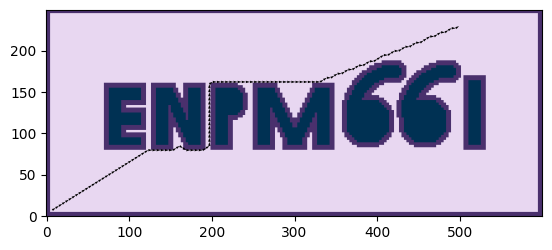

In [ ]:
fig, ax = plt.subplots()
# for b in closed_list:
#   if b.parent_node != None:
#     ax.quiver(b.parent_node.value[0], b.parent_node.value[1], b.value[0] - b.parent_node.value[0],b.value[1] - b.parent_node.value[1],scale_units="xy",scale=1,color="red")
# for b in open_list.queue:
#   if b.parent_node != None:
#     ax.quiver(b.parent_node.value[0], b.parent_node.value[1], b.value[0] - b.parent_node.value[0],b.value[1] - b.parent_node.value[1],scale_units="xy",scale=1,color="blue")
for b in final_path[1:]:
  ax.quiver(b.parent_node.value[0], b.parent_node.value[1], b.value[0] - b.parent_node.value[0],b.value[1] - b.parent_node.value[1],scale_units="xy",scale=1)
ax.set_aspect('equal')
plt.imshow(image,origin="lower")

In [ ]:
# Save image of path found
plt.imsave(f"solution_a*.jpg",frames[-1].astype(np.uint8))

In [ ]:
# Generate video
clip = ImageSequenceClip(frames, fps=24)
clip.write_videofile(f'output_astar.mp4')

Moviepy - Building video output_astar.mp4.
Moviepy - Writing video output_astar.mp4



Moviepy - Done !
Moviepy - video ready output_astar.mp4
